# Brick 23 Optical+IR Modelling and Fitting

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %config InlineBackend.figure_format='svg'

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cubehelix

import os
import time
from glob import glob
import numpy as np

brick = 23
STARFISH = os.getenv("STARFISH")
isoc_dir = "b23oir_isoc"
lib_dir = "b23oir_lib"
synth_dir = "b23oir_synth"
fit_oir_dir = "b23oir_fit_oir"
fit_opt_dir = "b23oir_fit_opt"
fit_ir_dir = "b23oir_fit_ir"
wfc3_bands = ['F475W', 'F814W', 'F110W', 'F160W']
wfc3_ir_bands = ['F110W', 'F160W']
wfc3_opt_bands = ['F475W', 'F814W']

## Load the PHAT dataset

In [3]:
from astropy.table import Table
from m31hst import phat_v2_phot_path

brick_table = Table.read(phat_v2_phot_path(brick), format='fits')

/Users/jsick/phat_data


## Prepare isochrones

In [4]:
from astropy.coordinates import Distance
import astropy.units as u

from padova import AgeGridRequest, IsochroneRequest
from starfisher import LibraryBuilder

z_grid = [0.015, 0.019, 0.024]
delta_gyr = 0.5
late_ages = np.log10(np.arange(1e9 + delta_gyr, 13e9, delta_gyr * 1e9))
if not os.path.exists(os.path.join(STARFISH, isoc_dir)):
    for z in z_grid:
        r = AgeGridRequest(z,
                           min_log_age=6.6,
                           max_log_age=10.13,
                           delta_log_age=0.02,
                           phot='wfc3', photsys_version='odfnew')
        for isoc in r.isochrone_set:
            isoc.export_for_starfish(os.path.join(STARFISH, isoc_dir),
                                     bands=wfc3_bands)

d = Distance(785 * u.kpc)
builder = LibraryBuilder(isoc_dir, lib_dir,
                         nmag=len(wfc3_bands),
                         dmod=d.distmod.value,
                         iverb=3)
if not os.path.exists(builder.full_isofile_path):
    builder.install()

## Bin isochrones

In [5]:
from collections import namedtuple
from starfisher import Lockfile
from starfisher import Synth
from starfisher import ExtinctionDistribution
from starfisher import ExtantCrowdingTable
from starfisher import MockNullCrowdingTable
from starfisher import ColorPlane
from starfisher import Mask
from m31hst.phatast import PhatAstTable

if not os.path.exists(os.path.join(STARFISH, synth_dir)):
    os.makedirs(os.path.join(STARFISH, synth_dir))

# No binning in our lockfile
# Each synth set gets its own lockfile because of some poor API decisions...
lockfile = Lockfile(builder.read_isofile(), synth_dir, unbinned=False)

# Bin young isochrones
young_grid = np.linspace(6.5, 8.95, 10)
for i, logage0 in enumerate(young_grid[:-1]):
    logage0 = logage0
    logage1 = young_grid[i + 1]
    z_str = "0019"
    mean_age = (logage0 + logage1) / 0.2
    name = "z{0}_{1:05.2f}".format(z_str, mean_age)
    lockfile.lock_box(name, (logage0, logage1), (0.014, 0.025))

# Bin old isochrones
old_grid = np.arange(1e9, 14 * 1e9, 1e9)
for i, age0 in enumerate(old_grid[:-1]):
    logage0 = np.log10(age0 - 0.05 * 1e9)
    logage1 = np.log10(old_grid[i + 1])
    z_str = "0019"
    mean_age = (logage0 + logage1) / 0.2
    name = "z{0}_{1:05.2f}".format(z_str, mean_age)
    lockfile.lock_box(name, (logage0, logage1), (0.014, 0.025))

/Users/jsick/.virtualenvs/starfish/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


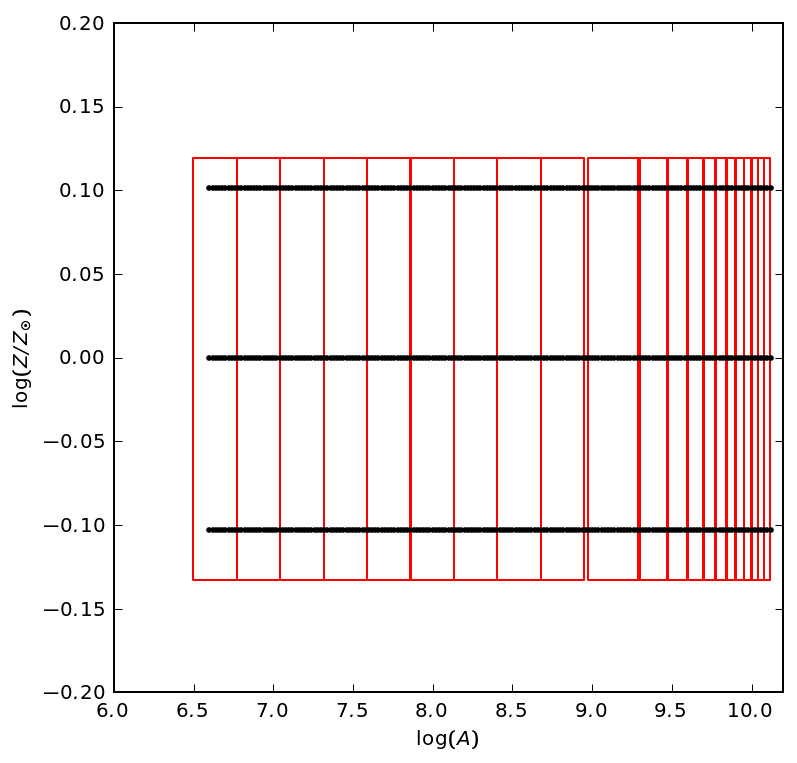

In [6]:
from starfisher.plots import plot_lock_polygons, plot_isochrone_logage_logzsol

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
plot_isochrone_logage_logzsol(ax, builder, c='k', s=8)
plot_lock_polygons(ax, lockfile, facecolor='None', edgecolor='r')
ax.set_xlim(6, 10.2)
ax.set_ylim(-0.2, 0.2)
ax.set_xlabel(r"$\log(A)$")
ax.set_ylabel(r"$\log(Z/Z_\odot)$")
fig.show()

## Define CMD Planes

In [7]:
# Define CMD planes
Lim = namedtuple('Lim', 'x y')

ir_lim = Lim(x=(0.3, 1.3), y=(24, 16.5))
ir_cmd = ColorPlane((wfc3_bands.index('F110W'),
                     wfc3_bands.index('F160W')),
                    wfc3_bands.index('F160W'),
                    ir_lim.x,
                    (min(ir_lim.y), max(ir_lim.y)),
                    30.,
                    suffix='f110f160',
                    x_label=r'$\mathrm{F110W}-\mathrm{F160W}$',
                    y_label=r'$\mathrm{F110W}$',
                    dpix=0.05)
ir_cmd.mask_region((-1., 0.), (22., 16))
ir_cmd.mask_region((0, 0.3), (22., 16))
ir_cmd.mask_region((0.3, 0.7), (20., 16))
ir_cmd.mask_region((0.7, 0.8), (19., 16))
ir_cmd.mask_region((0.8, 0.9), (18., 16))
ir_cmd.mask_region((1.1, 1.5), (28, 21))

opt_lim = Lim(x=(-1, 5), y=(25.5, 20))
opt_cmd = ColorPlane((wfc3_bands.index('F475W'),
                     wfc3_bands.index('F814W')),
                     wfc3_bands.index('F814W'),
                     opt_lim.x,
                     (min(opt_lim.y), max(opt_lim.y)),
                     30.,
                     suffix='f475f814',
                     x_label=r'$\mathrm{F475W}-\mathrm{F814W}$',
                     y_label=r'$\mathrm{F814W}$',
                     dpix=0.05)
opt_cmd.mask_region((3, 5), (28, 25))
opt_cmd.mask_region((3.5, 5), (25, 23))
opt_cmd.mask_region((4, 5), (23, 22.5))

oir_planes = [opt_cmd, ir_cmd]
ir_planes = [ir_cmd]
opt_planes = [opt_cmd]

## Synthesize Optical and NIR CMD Planes

In [8]:
full_synth_dir = os.path.join(STARFISH, synth_dir)
if not os.path.exists(full_synth_dir):
    os.makedirs(full_synth_dir)

# Use PHAT AST from the outer field (field 0)
crowd_path = os.path.join(synth_dir, "crowding.dat")
full_crowd_path = os.path.join(STARFISH, crowd_path)
tbl = PhatAstTable()
tbl.write_crowdfile_for_field(full_crowd_path, 0,
                              bands=('f475w', 'f814w', 'f110w', 'f160w'))
crowd = ExtantCrowdingTable(crowd_path)

# No extinction, yet
young_av = ExtinctionDistribution()
old_av = ExtinctionDistribution()
rel_extinction = np.ones(len(wfc3_bands), dtype=float)
for av in (young_av, old_av):
    av.set_uniform(0.)

synth = Synth(synth_dir, builder, lockfile, crowd,
                  rel_extinction,
                  young_extinction=young_av,
                  old_extinction=old_av,
                  planes=oir_planes,
                  mass_span=(0.08, 150.),
                  nstars=10000000)
if len(glob(os.path.join(STARFISH, synth_dir, "z*"))) == 0:
    synth.run_synth(n_cpu=4)

## Visualization of the simulated Hess planes

In [9]:
from starfisher import SimHess

optsim = SimHess(synth, opt_cmd, np.ones(len(lockfile.active_groups)))
irsim = SimHess(synth, ir_cmd, np.ones(len(lockfile.active_groups)))

/Users/jsick/code/_starfish/starfisher/starfisher/plots.py:54: RuntimeWarning: divide by zero encountered in log10
  hess = np.log10(hess)
/Users/jsick/.virtualenvs/starfish/lib/python2.7/site-packages/matplotlib/contour.py:931: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


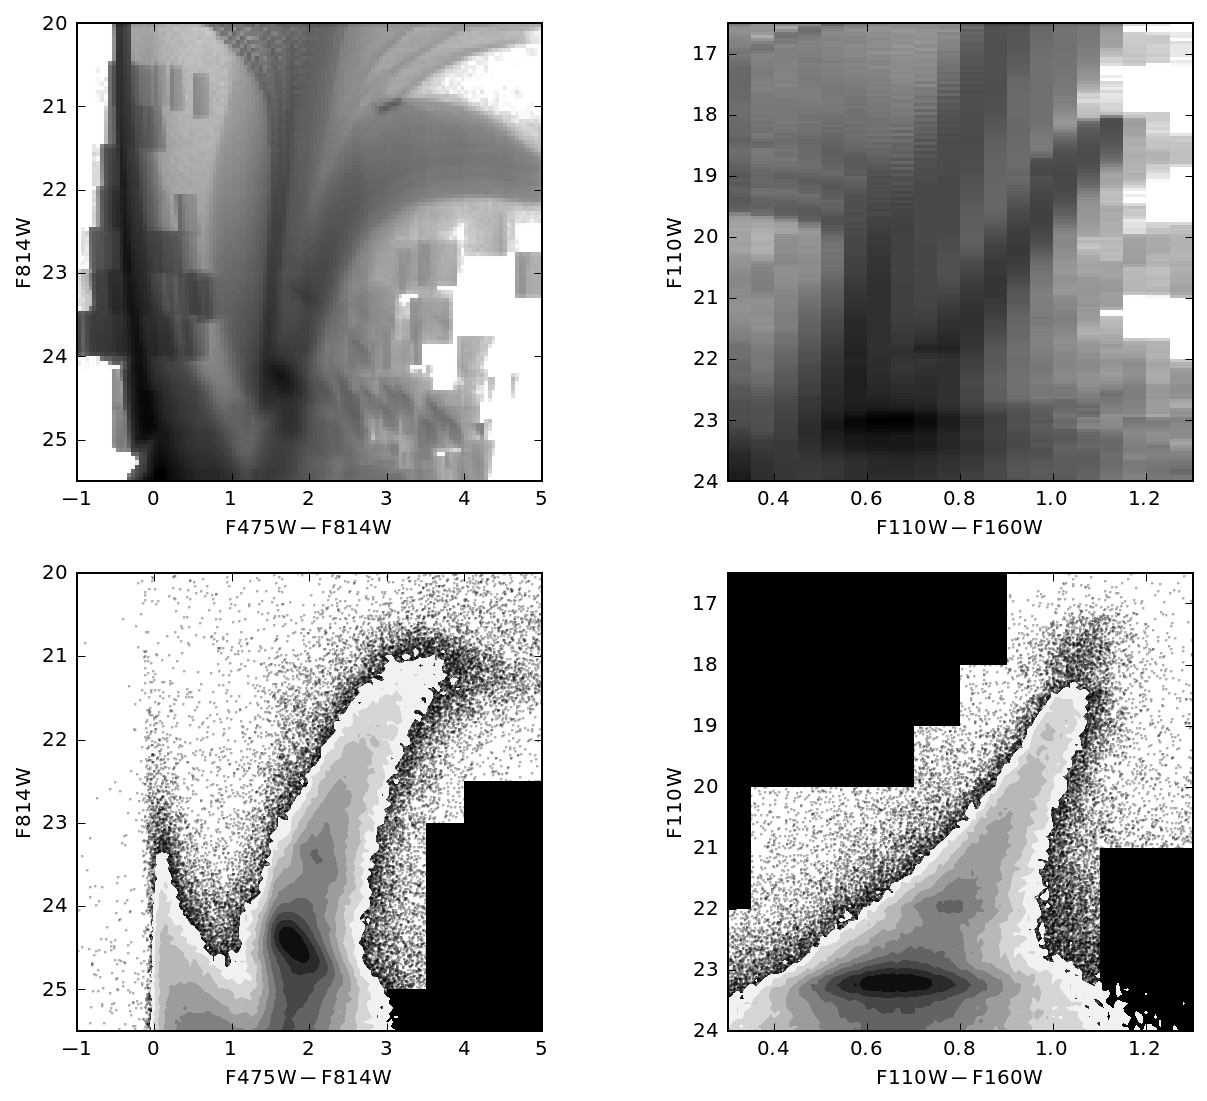

In [10]:
from starfisher.plots import plot_hess
from androcmd.plot import contour_hess

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, wspace=0.4, bottom=0.2)
ax_opt = fig.add_subplot(gs[0, 0])
ax_ir = fig.add_subplot(gs[0, 1])
ax_obs_opt = fig.add_subplot(gs[1, 0])
ax_obs_ir = fig.add_subplot(gs[1, 1])

plot_hess(ax_opt, optsim.hess, opt_cmd, optsim.origin, imshow_args=None)
plot_hess(ax_ir, irsim.hess, ir_cmd, irsim.origin, imshow_args=None)

contour_hess(ax_obs_opt, brick_table['f475w_vega'] - brick_table['f814w_vega'],
             brick_table['f814w_vega'], opt_cmd.x_span, opt_cmd.y_span,
             plot_args={'ms': 3})
opt_cmd.plot_mask(ax_obs_opt)
ax_obs_opt.set_xlabel(opt_cmd.x_label)
ax_obs_opt.set_ylabel(opt_cmd.y_label)
ax_obs_opt.set_xlim(opt_cmd.xlim)
ax_obs_opt.set_ylim(opt_cmd.ylim)

contour_hess(ax_obs_ir, brick_table['f110w_vega'] - brick_table['f160w_vega'],
             brick_table['f160w_vega'], ir_cmd.x_span, ir_cmd.y_span,
             plot_args={'ms': 3})
ir_cmd.plot_mask(ax_obs_ir)
ax_obs_ir.set_xlabel(ir_cmd.x_label)
ax_obs_ir.set_ylabel(ir_cmd.y_label)
ax_obs_ir.set_xlim(ir_cmd.xlim)
ax_obs_ir.set_ylim(ir_cmd.ylim)

fig.show()

### Mean ages across the Hess diagram (given uniform age distribution)

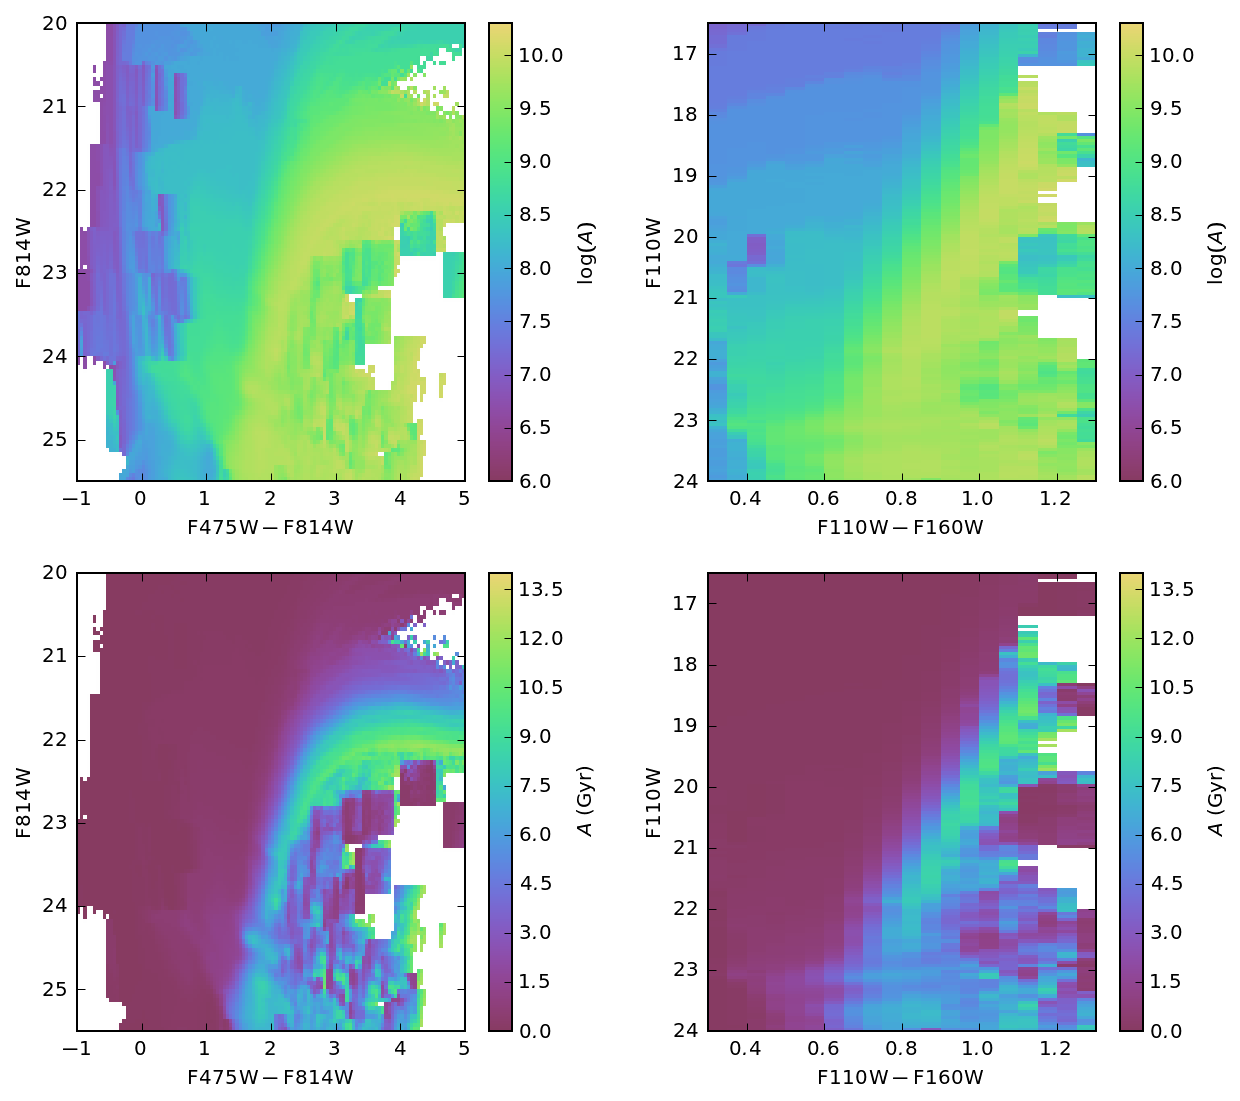

In [11]:
cmapper = lambda: cubehelix.cmap(startHue=240,endHue=-300,minSat=1,maxSat=2.5,minLight=.3,maxLight=.8,gamma=.9)
log_imshow_args = {'cmap': cmapper(), 'vmin': 6., 'vmax': 10.3}
lin_imshow_args = {'cmap': cmapper(), 'vmin': 0., 'vmax': 14.}
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, wspace=0.3, hspace=0.2, bottom=0.2)
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])

im = plot_hess(ax00, optsim.mean_logage_hess, opt_cmd, optsim.origin,
               log=False, imshow_args=log_imshow_args)
cb = fig.colorbar(im, ax=ax00)
cb.set_label(r"$\log(A)$")

im = plot_hess(ax01, irsim.mean_logage_hess, ir_cmd, irsim.origin,
               log=False, imshow_args=log_imshow_args)
cb = fig.colorbar(im, ax=ax01)
cb.set_label(r"$\log(A)$")

im = plot_hess(ax10, 10 ** optsim.mean_logage_hess / 1e9, opt_cmd, optsim.origin,
               log=False, imshow_args=lin_imshow_args)
cb = fig.colorbar(im, ax=ax10)
cb.set_label(r"$A$ (Gyr)")

im = plot_hess(ax11, 10 ** irsim.mean_logage_hess / 1e9, ir_cmd, irsim.origin,
               log=False, imshow_args=lin_imshow_args)
cb = fig.colorbar(im, ax=ax11)
cb.set_label(r"$A$ (Gyr)")

fig.show()

## Fit the Optical+IR Hess Planes

In [12]:
if not os.path.exists(os.path.join(STARFISH, fit_oir_dir)):
    os.makedirs(os.path.join(STARFISH, fit_oir_dir))

data_oir_root = os.path.join(fit_oir_dir, "b23.")
full_data_oir_ir_path = os.path.join(STARFISH, '{0}f110f160'.format(data_oir_root))
full_data_oir_opt_path = os.path.join(STARFISH, '{0}f475f814'.format(data_oir_root))
if not os.path.exists(full_data_oir_ir_path):
    phot_dtype = np.dtype([('x', np.float), ('y', np.float)])
    photdata = np.empty(len(brick_table), dtype=phot_dtype)
    photdata['x'][:] = brick_table['f475w_vega'] - brick_table['f814w_vega']
    photdata['y'][:] = brick_table['f814w_vega']
    np.savetxt(full_data_oir_opt_path, photdata, delimiter=' ', fmt='%.4f')
    photdata['x'][:] = brick_table['f110w_vega'] - brick_table['f160w_vega']
    photdata['y'][:] = brick_table['f160w_vega']    
    np.savetxt(full_data_oir_ir_path, photdata, delimiter=' ', fmt='%.4f')

In [13]:
from starfisher import SFH
sfh_oir = SFH(data_oir_root, synth, fit_oir_dir, planes=oir_planes)
if not os.path.exists(sfh_oir.full_outfile_path):
    sfh_oir.run_sfh()
sfh_oir_table = sfh_oir.solution_table()

### Visualization of the OIR SFH Model

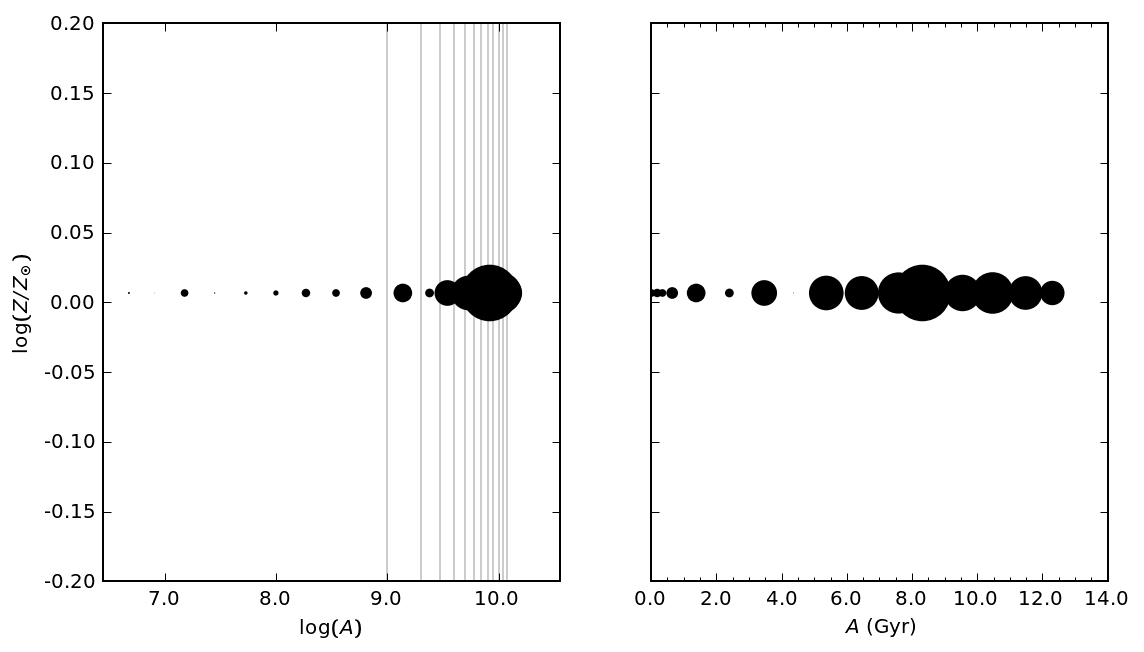

In [14]:
from starfisher.sfhplot import LinearSFHCirclePlot, SFHCirclePlot

fig = plt.figure(figsize=(9, 5))
ax_log = fig.add_subplot(121)
ax_lin = fig.add_subplot(122)

cp = SFHCirclePlot(sfh_oir_table)
cp.plot_in_ax(ax_log, max_area=800)
for logage in np.log10(np.arange(1, 13, 1) * 1e9):
    ax_log.axvline(logage, c='0.8', zorder=-1)
ax_log.set_ylim(-0.2, 0.2)

cp = LinearSFHCirclePlot(sfh_oir_table)
cp.plot_in_ax(ax_lin, max_area=800)
for tl in ax_lin.get_ymajorticklabels():
    tl.set_visible(False)
ax_lin.set_ylabel("")
ax_lin.set_ylim(-0.2, 0.2)
fig.show()

/Users/jsick/code/_starfish/starfisher/starfisher/sfhplot.py:175: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(self.obs_hess), **a)
/Users/jsick/code/_starfish/starfisher/starfisher/sfhplot.py:166: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(self.mod_hess), **a)
/Users/jsick/code/_starfish/starfisher/starfisher/sfhplot.py:184: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(self.chi_hess), **a)


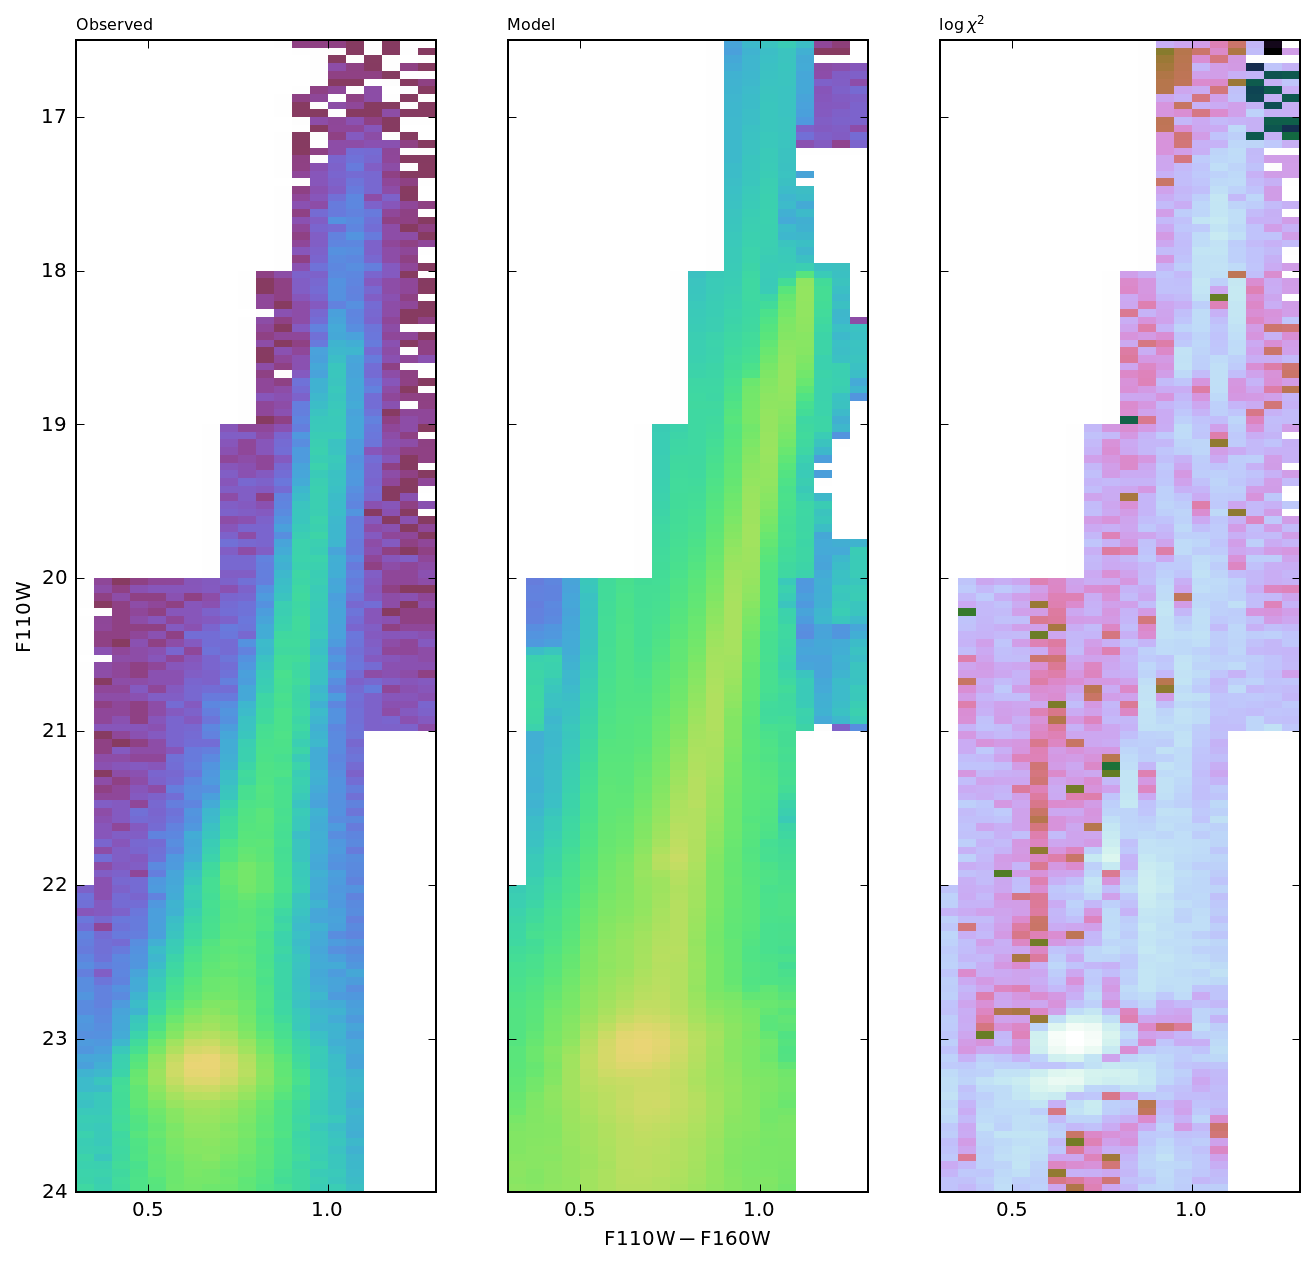

In [15]:
import cubehelix
cmapper = lambda: cubehelix.cmap(startHue=240,endHue=-300,minSat=1,maxSat=2.5,
                                 minLight=.3,maxLight=.8,gamma=.9)

from starfisher.sfhplot import ChiTriptykPlot
fig = plt.figure(figsize=(10, 10))
ctp = ChiTriptykPlot(sfh_oir, ir_cmd)
ax_obs_ir, ax_mod_ir, ax_chi_ir = ctp.setup_axes(fig)
ctp.plot_obs_in_ax(ax_obs_ir, cmap=cmapper())
ctp.plot_mod_in_ax(ax_mod_ir, cmap=cmapper())
ctp.plot_chi_in_ax(ax_chi_ir, cmap=cubehelix.cmap())
ax_obs_ir.text(0.0, 1.01, "Observed", transform=ax_obs_ir.transAxes, size=8, ha='left')
ax_mod_ir.text(0.0, 1.01, "Model", transform=ax_mod_ir.transAxes, size=8, ha='left')
ax_chi_ir.text(0.0, 1.01, r"$\log \chi^2$", transform=ax_chi_ir.transAxes, size=8, ha='left')
fig.show()

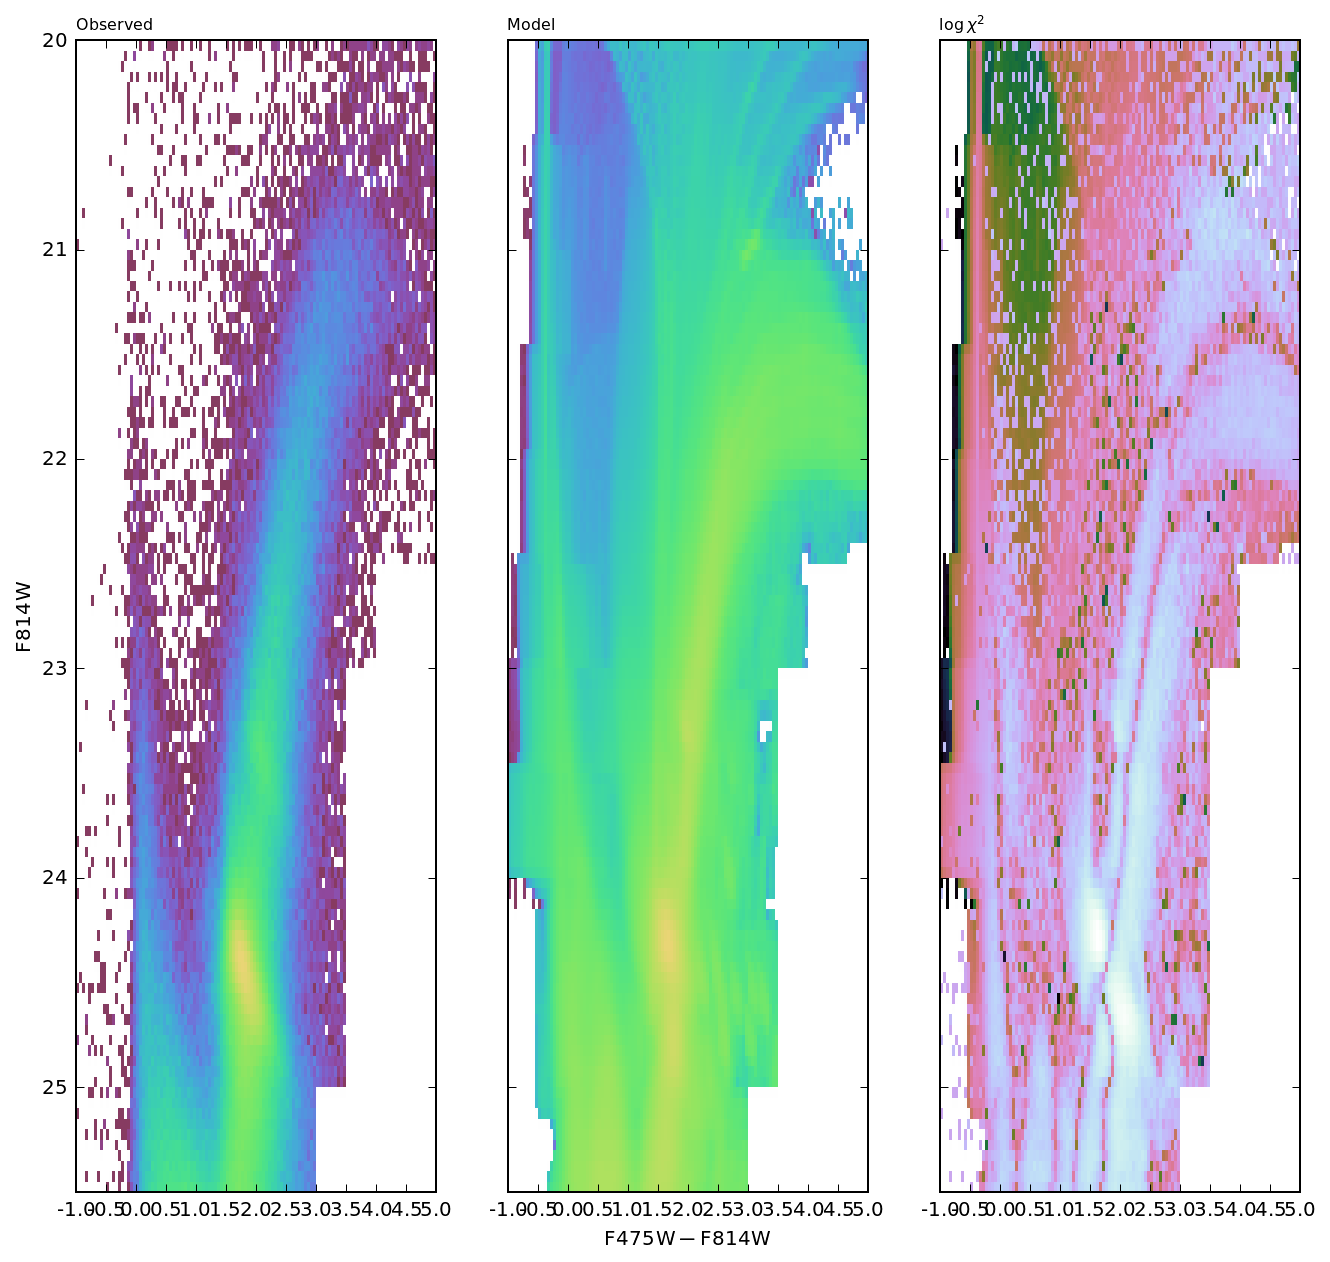

In [16]:
fig = plt.figure(figsize=(10, 10))
ctp = ChiTriptykPlot(sfh_oir, opt_cmd)
ax_obs_opt, ax_mod_opt, ax_chi_opt = ctp.setup_axes(fig)
ctp.plot_obs_in_ax(ax_obs_opt, cmap=cmapper())
ctp.plot_mod_in_ax(ax_mod_opt, cmap=cmapper())
ctp.plot_chi_in_ax(ax_chi_opt, cmap=cubehelix.cmap())
ax_obs_opt.text(0.0, 1.01, "Observed", transform=ax_obs_opt.transAxes, size=8, ha='left')
ax_mod_opt.text(0.0, 1.01, "Model", transform=ax_mod_opt.transAxes, size=8, ha='left')
ax_chi_opt.text(0.0, 1.01, r"$\log \chi^2$", transform=ax_chi_opt.transAxes, size=8, ha='left')
fig.show()

## Fitting the Optical-CMD only

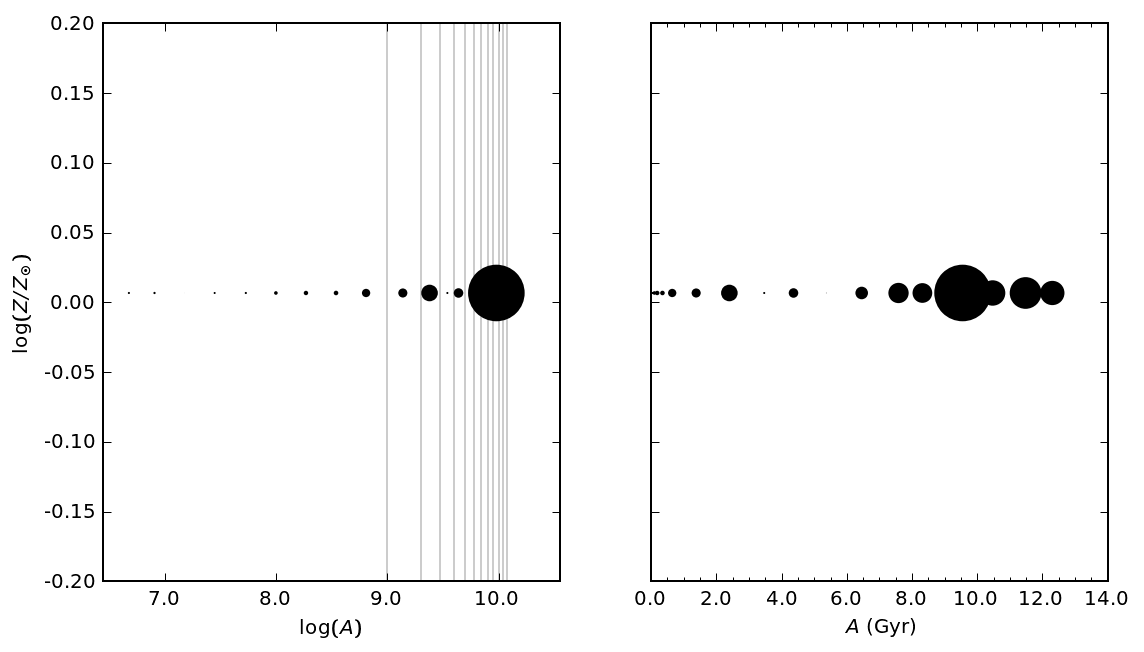

In [17]:
if not os.path.exists(os.path.join(STARFISH, fit_opt_dir)):
    os.makedirs(os.path.join(STARFISH, fit_opt_dir))
data_opt_root = os.path.join(fit_opt_dir, "b23.")
full_data_opt_opt_path = os.path.join(STARFISH, '{0}f475f814'.format(data_opt_root))
if not os.path.exists(full_data_opt_opt_path):
    phot_dtype = np.dtype([('x', np.float), ('y', np.float)])
    photdata = np.empty(len(brick_table), dtype=phot_dtype)
    photdata['x'][:] = brick_table['f475w_vega'] - brick_table['f814w_vega']
    photdata['y'][:] = brick_table['f814w_vega']
    np.savetxt(full_data_opt_opt_path, photdata, delimiter=' ', fmt='%.4f')
sfh_opt = SFH(data_opt_root, synth, fit_opt_dir, planes=opt_planes)
if not os.path.exists(sfh_opt.full_outfile_path):
    sfh_opt.run_sfh()
sfh_opt_table = sfh_opt.solution_table()

fig = plt.figure(figsize=(9, 5))
ax_log = fig.add_subplot(121)
ax_lin = fig.add_subplot(122)

cp = SFHCirclePlot(sfh_opt_table)
cp.plot_in_ax(ax_log, max_area=800)
for logage in np.log10(np.arange(1, 13, 1) * 1e9):
    ax_log.axvline(logage, c='0.8', zorder=-1)
ax_log.set_ylim(-0.2, 0.2)

cp = LinearSFHCirclePlot(sfh_opt_table)
cp.plot_in_ax(ax_lin, max_area=800)
for tl in ax_lin.get_ymajorticklabels():
    tl.set_visible(False)
ax_lin.set_ylabel("")
ax_lin.set_ylim(-0.2, 0.2)
fig.show()

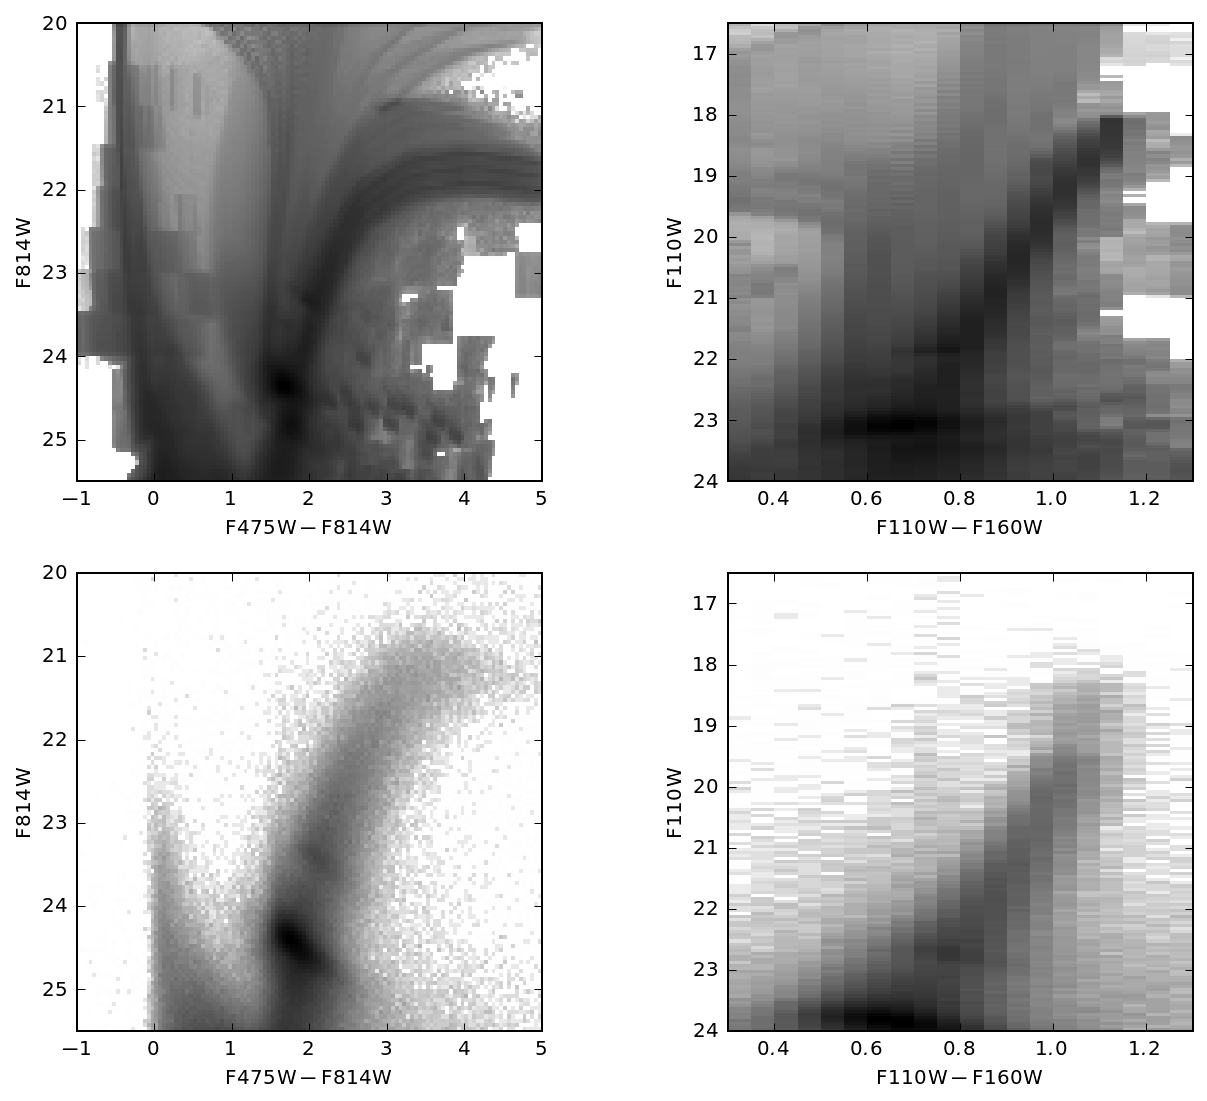

In [24]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, wspace=0.4, bottom=0.2)
ax_opt = fig.add_subplot(gs[0, 0])
ax_ir = fig.add_subplot(gs[0, 1])
ax_obs_opt = fig.add_subplot(gs[1, 0])
ax_obs_ir = fig.add_subplot(gs[1, 1])

opt_sim_hess = SimHess.from_sfh_solution(sfh_opt, opt_cmd)
ir_sim_hess = SimHess.from_sfh_solution(sfh_opt, ir_cmd)
plot_hess(ax_opt, opt_sim_hess.hess, opt_cmd, opt_sim_hess.origin, imshow_args=None)
plot_hess(ax_ir, ir_sim_hess.hess, ir_cmd, ir_sim_hess.origin, imshow_args=None)

opt_obs_hess = StarCatalogHess(brick_table['f475w_vega'] - brick_table['f814w_vega'],
                               brick_table['f814w_vega'],
                               opt_cmd)
plot_hess(ax_obs_opt, opt_obs_hess.hess, opt_cmd, opt_obs_hess.origin, imshow_args=None)
ax_obs_opt.set_xlabel(opt_cmd.x_label)
ax_obs_opt.set_ylabel(opt_cmd.y_label)
ax_obs_opt.set_xlim(opt_cmd.xlim)
ax_obs_opt.set_ylim(opt_cmd.ylim)

ir_obs_hess = StarCatalogHess(brick_table['f110w_vega'] - brick_table['f160w_vega'],
                              brick_table['f110w_vega'],
                              ir_cmd)
plot_hess(ax_obs_ir, ir_obs_hess.hess, ir_cmd, ir_obs_hess.origin, imshow_args=None)
ax_obs_ir.set_xlabel(ir_cmd.x_label)
ax_obs_ir.set_ylabel(ir_cmd.y_label)
ax_obs_ir.set_xlim(ir_cmd.xlim)
ax_obs_ir.set_ylim(ir_cmd.ylim)

fig.show()

## Fitting the IR CMD only

In [19]:
if not os.path.exists(os.path.join(STARFISH, fit_ir_dir)):
    os.makedirs(os.path.join(STARFISH, fit_ir_dir))
data_ir_root = os.path.join(fit_ir_dir, "b23.")
full_data_ir_ir_path = os.path.join(STARFISH, '{0}f110f160'.format(data_ir_root))
if not os.path.exists(full_data_ir_ir_path):
    phot_dtype = np.dtype([('x', np.float), ('y', np.float)])
    photdata = np.empty(len(brick_table), dtype=phot_dtype)
    photdata['x'][:] = brick_table['f110w_vega'] - brick_table['f160w_vega']
    photdata['y'][:] = brick_table['f160w_vega']    
    np.savetxt(full_data_ir_ir_path, photdata, delimiter=' ', fmt='%.4f')
sfh_ir = SFH(data_ir_root, synth, fit_ir_dir, planes=ir_planes)
if not os.path.exists(sfh_ir.full_outfile_path):
    sfh_ir.run_sfh()
sfh_ir_table = sfh_ir.solution_table()

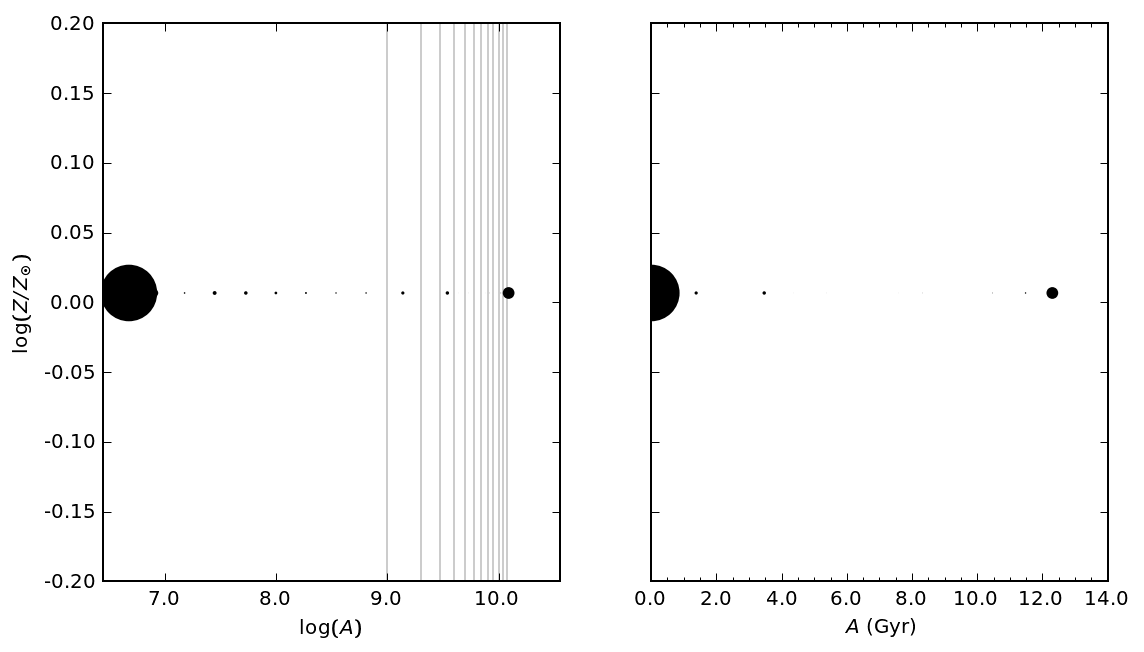

In [20]:
fig = plt.figure(figsize=(9, 5))
ax_log = fig.add_subplot(121)
ax_lin = fig.add_subplot(122)

cp = SFHCirclePlot(sfh_ir_table)
cp.plot_in_ax(ax_log, max_area=800)
for logage in np.log10(np.arange(1, 13, 1) * 1e9):
    ax_log.axvline(logage, c='0.8', zorder=-1)
ax_log.set_ylim(-0.2, 0.2)

cp = LinearSFHCirclePlot(sfh_ir_table)
cp.plot_in_ax(ax_lin, max_area=800)
for tl in ax_lin.get_ymajorticklabels():
    tl.set_visible(False)
ax_lin.set_ylabel("")
ax_lin.set_ylim(-0.2, 0.2)
fig.show()

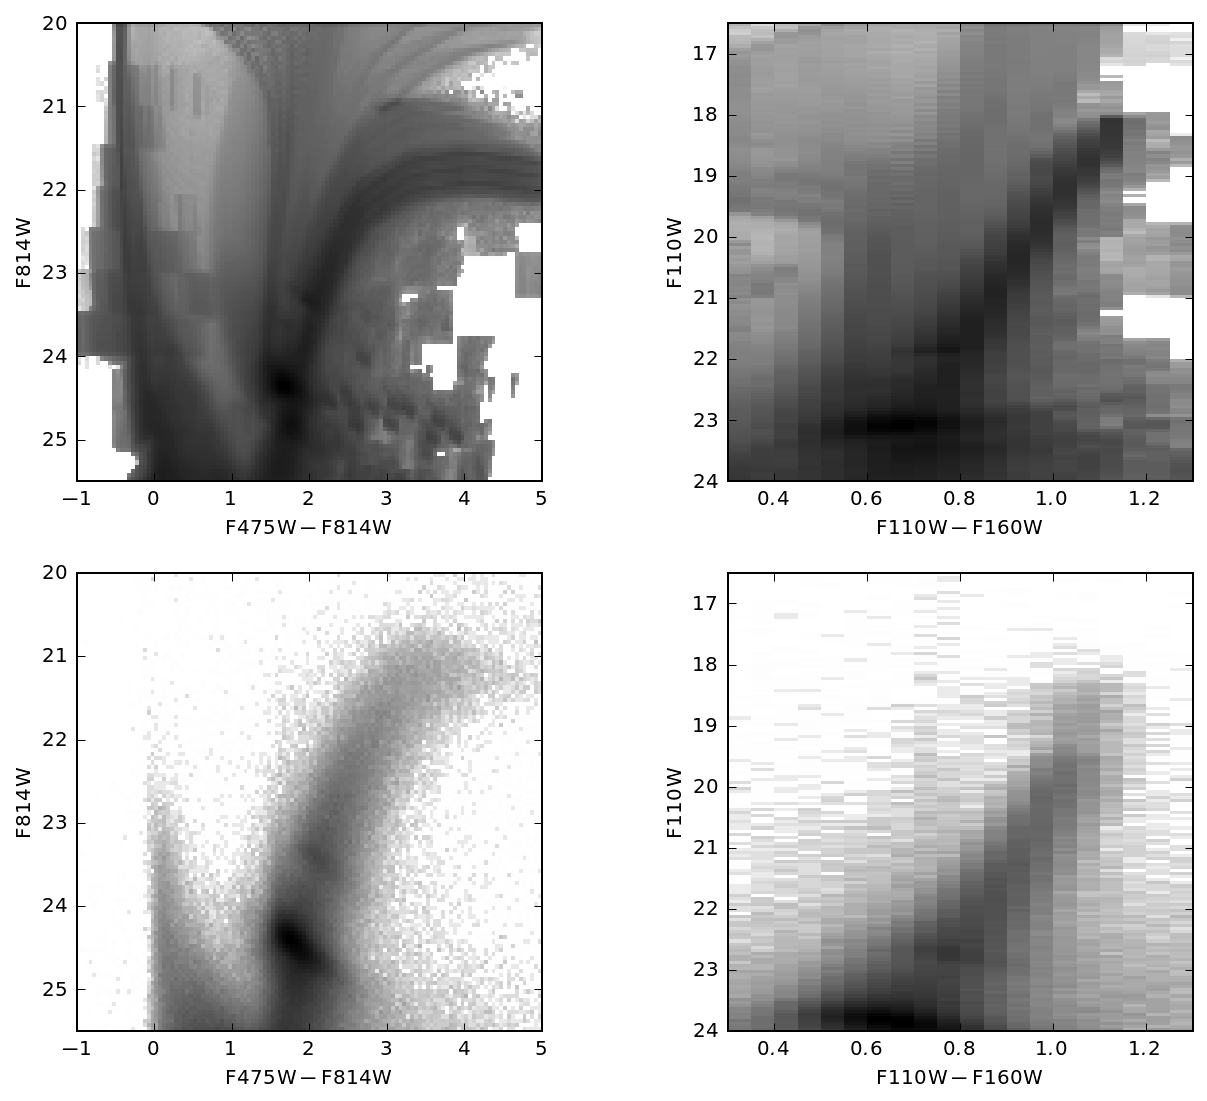

In [22]:
from starfisher import StarCatalogHess

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, wspace=0.4, bottom=0.2)
ax_opt = fig.add_subplot(gs[0, 0])
ax_ir = fig.add_subplot(gs[0, 1])
ax_obs_opt = fig.add_subplot(gs[1, 0])
ax_obs_ir = fig.add_subplot(gs[1, 1])

opt_sim_hess = SimHess.from_sfh_solution(sfh_opt, opt_cmd)
ir_sim_hess = SimHess.from_sfh_solution(sfh_opt, ir_cmd)
plot_hess(ax_opt, opt_sim_hess.hess, opt_cmd, opt_sim_hess.origin, imshow_args=None)
plot_hess(ax_ir, ir_sim_hess.hess, ir_cmd, ir_sim_hess.origin, imshow_args=None)

opt_obs_hess = StarCatalogHess(brick_table['f475w_vega'] - brick_table['f814w_vega'],
                               brick_table['f814w_vega'],
                               opt_cmd)
plot_hess(ax_obs_opt, opt_obs_hess.hess, opt_cmd, opt_obs_hess.origin, imshow_args=None)
ax_obs_opt.set_xlabel(opt_cmd.x_label)
ax_obs_opt.set_ylabel(opt_cmd.y_label)
ax_obs_opt.set_xlim(opt_cmd.xlim)
ax_obs_opt.set_ylim(opt_cmd.ylim)

ir_obs_hess = StarCatalogHess(brick_table['f110w_vega'] - brick_table['f160w_vega'],
                              brick_table['f110w_vega'],
                              ir_cmd)
plot_hess(ax_obs_ir, ir_obs_hess.hess, ir_cmd, ir_obs_hess.origin, imshow_args=None)
ax_obs_ir.set_xlabel(ir_cmd.x_label)
ax_obs_ir.set_ylabel(ir_cmd.y_label)
ax_obs_ir.set_xlim(ir_cmd.xlim)
ax_obs_ir.set_ylim(ir_cmd.ylim)

fig.show()